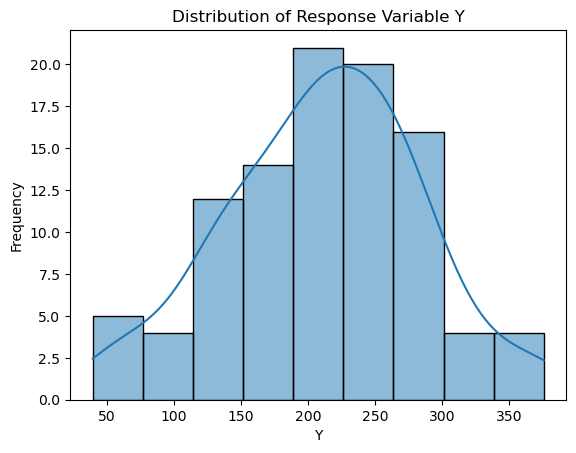

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Load the data
data = pd.read_csv('case1Data.csv')
data_xnew = pd.read_csv('case1Data_Xnew.csv')

# Visualize the distribution of the response variable Y
sns.histplot(data['y'], kde=True)
plt.title('Distribution of Response Variable Y')
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.show()


## STANDARDIZE DATA

In [13]:

#STANDARDIZE THE DATA
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


# MISSING VALUES

In [14]:
# Check for missing values
data = data_scaled
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Count the number of rows with missing data
rows_with_missing_data = data.isnull().any(axis=1).sum()
print("Number of rows with missing data:", rows_with_missing_data)

# Calculate the total percentage of missing data
total_missing = data.isnull().sum().sum()
total_missing_percentage = data.isnull().sum().sum() / (data.shape[0] * data.shape[1]) * 100
print("Total number of missing data:", total_missing)
print("Total percentage of missing data:", total_missing_percentage)
print("total data:", data.shape[0] * data.shape[1])



Missing values in each column:
 y        0
x_01    13
x_02    21
x_03    15
x_04    14
        ..
C_01    22
C_02    22
C_03    22
C_04    22
C_05    22
Length: 101, dtype: int64
Number of rows with missing data: 100
Total number of missing data: 1489
Total percentage of missing data: 14.742574257425742
total data: 10100


In [15]:
# NOT SO GREAT OPTIONS SINCE THE PERCENTAGE OF MISSING DATA IS HIGH
# Option 1: Remove rows with missing values
data_dropped_rows = data.dropna()
print("Data after dropping rows with missing values:\n", data_dropped_rows)

# Option 2: Remove columns with missing values
data_dropped_columns = data.dropna(axis=1)
print("Data after dropping columns with missing values:\n", data_dropped_columns)

Data after dropping rows with missing values:
 Empty DataFrame
Columns: [y, x_01, x_02, x_03, x_04, x_05, x_06, x_07, x_08, x_09, x_10, x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20, x_21, x_22, x_23, x_24, x_25, x_26, x_27, x_28, x_29, x_30, x_31, x_32, x_33, x_34, x_35, x_36, x_37, x_38, x_39, x_40, x_41, x_42, x_43, x_44, x_45, x_46, x_47, x_48, x_49, x_50, x_51, x_52, x_53, x_54, x_55, x_56, x_57, x_58, x_59, x_60, x_61, x_62, x_63, x_64, x_65, x_66, x_67, x_68, x_69, x_70, x_71, x_72, x_73, x_74, x_75, x_76, x_77, x_78, x_79, x_80, x_81, x_82, x_83, x_84, x_85, x_86, x_87, x_88, x_89, x_90, x_91, x_92, x_93, x_94, x_95, C_01, C_02, C_03, C_04, ...]
Index: []

[0 rows x 101 columns]
Data after dropping columns with missing values:
            y
0   2.278388
1   0.766718
2   0.773097
3   0.116900
4   1.084083
..       ...
95 -0.444091
96 -0.700068
97 -0.985720
98 -0.125879
99 -0.130433

[100 rows x 1 columns]


### BEST OPTIONS, MEAN AND MEDIAN VALUES 

In [16]:
# 1) Load data
X = data_scaled.iloc[:, 1:].values 
y = data_scaled.iloc[:, 0].values

# Separate continuous columns
continuous_cols = data_scaled.columns[1:-5]

# 2) Mean Imputation
mean_imputer = SimpleImputer(strategy='mean')
X_mean_imputed = mean_imputer.fit_transform(data_scaled[continuous_cols].values)

# 3) Median Imputation
median_imputer = SimpleImputer(strategy='median')
X_median_imputed = median_imputer.fit_transform(data_scaled[continuous_cols].values)

# 5) Elastic Net Regression
elas = ElasticNet()

# 6) Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 7) Evaluate Mean Imputation
scores_mean = cross_val_score(elas, X_mean_imputed, y, cv=cv, scoring='neg_mean_squared_error')
mse_mean = -scores_mean
print("Mean Imputation MSE per fold:", mse_mean)
print("Mean Imputation MSE (avg +/- std): %.4f +/- %.4f" % (mse_mean.mean(), mse_mean.std()))

# 8) Evaluate Median Imputation
scores_median = cross_val_score(elas, X_median_imputed, y, cv=cv, scoring='neg_mean_squared_error')
mse_median = -scores_median
print("Median Imputation MSE per fold:", mse_median)
print("Median Imputation MSE (avg +/- std): %.4f +/- %.4f" % (mse_median.mean(), mse_median.std()))

# Compare the average MSE
if mse_mean.mean() < mse_median.mean():
    print("\nMean Imputation yields a lower average MSE, so it may be better.")
else:
    print("\nMedian Imputation yields a lower average MSE, so it may be better.")

# Save the results in new dataframes



Mean Imputation MSE per fold: [1.11431929 0.66562237 0.42091103 1.08979967 0.94577428]
Mean Imputation MSE (avg +/- std): 0.8473 +/- 0.2663
Median Imputation MSE per fold: [1.11737812 0.66781773 0.42250391 1.09236745 0.94805618]
Median Imputation MSE (avg +/- std): 0.8496 +/- 0.2668

Mean Imputation yields a lower average MSE, so it may be better.


I checked this 2 imputers only on the first 95 variables since these are the continuous ones. For the categorical ones I will take the most frequent value and impute it 

In [17]:

# Separate numerical and categorical columns
num_cols = data.columns[:-5]
cat_cols = data.columns[-5:]

# Create imputers
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputers on the respective columns
X_num_imputed = num_imputer.fit_transform(data[num_cols])
X_cat_imputed = cat_imputer.fit_transform(data[cat_cols])

# Combine the imputed numerical and categorical data
X_imputed = np.hstack((X_num_imputed, X_cat_imputed))

# Convert the combined data back to a DataFrame
df_filled = pd.DataFrame(X_imputed, columns=num_cols.tolist() + cat_cols.tolist())

# FEATURES HANDLING FOR CATEGORICAL VARIABLES

In [18]:
# Define X and y
X = df_filled.drop(columns=['y'])
y = df_filled['y']

# Separate numerical and categorical columns
cat_cols = X.columns[-5:].tolist()  # e.g. last 5 columns
num_cols = [c for c in X.columns if c not in cat_cols]

# Impute numerical columns
num_imputer = SimpleImputer(strategy="mean")
X_num_imputed = num_imputer.fit_transform(X[num_cols])

# Impute and encode categorical columns using Ordinal Encoding
cat_imputer = SimpleImputer(strategy="most_frequent")
X_cat_imputed = cat_imputer.fit_transform(X[cat_cols])
ordinal_encoder = OrdinalEncoder()
X_cat_ordinal_encoded = ordinal_encoder.fit_transform(X_cat_imputed)

# Combine numerical and ordinal encoded categorical data
X_ordinal = np.hstack((X_num_imputed, X_cat_ordinal_encoded))

# Impute and encode categorical columns using One-Hot Encoding
onehot_encoder = OneHotEncoder(handle_unknown="ignore")
X_cat_onehot_encoded = onehot_encoder.fit_transform(X_cat_imputed).toarray()

# Combine numerical and one-hot encoded categorical data
X_onehot = np.hstack((X_num_imputed, X_cat_onehot_encoded))

# Evaluate each encoding method using Ridge regression and cross-validation
ridge = ElasticNet()
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores_ord = cross_val_score(ridge, X_ordinal, y, cv=cv, scoring="neg_mean_squared_error")
scores_oh = cross_val_score(ridge, X_onehot, y, cv=cv, scoring="neg_mean_squared_error")

mse_ord = -scores_ord  # convert from negative MSE
mse_oh = -scores_oh

print("Ordinal Encoding MSE per fold:", mse_ord)
print("Ordinal Encoding MSE Mean ± Std: %.4f ± %.4f" % (mse_ord.mean(), mse_ord.std()))
print("One-Hot Encoding MSE per fold:", mse_oh)
print("One-Hot Encoding MSE Mean ± Std: %.4f ± %.4f" % (mse_oh.mean(), mse_oh.std()))

# Decide which encoding is "better"
if mse_ord.mean() < mse_oh.mean():
    print("\nOrdinal encoding yields a lower average MSE, so it may be better.")
else:
    print("\nOne-hot encoding yields a lower average MSE, so it may be better.")


Ordinal Encoding MSE per fold: [1.11431929 0.66562237 0.42091103 1.08979967 0.94577428]
Ordinal Encoding MSE Mean ± Std: 0.8473 ± 0.2663
One-Hot Encoding MSE per fold: [1.11431929 0.66562237 0.42091103 1.08979967 0.94577428]
One-Hot Encoding MSE Mean ± Std: 0.8473 ± 0.2663

One-hot encoding yields a lower average MSE, so it may be better.


## Encoding Categorical Variables

In this analysis, we did not have context about the categorical variables. Even though some categorical values might seem ordinal, we decided to evaluate the encoding methods using Mean Squared Error (MSE) calculation and cross-validation. 

We compared two encoding methods:
1. **Ordinal Encoding**
2. **One-Hot Encoding**

After performing cross-validation, the results indicated that One-Hot Encoding yielded a lower average MSE compared to Ordinal Encoding. Therefore, One-Hot Encoding was chosen as the better method for encoding the categorical variables in this dataset.

In [19]:
X_preprocessed = X_onehot
y = y

# MODEL SELECTION

In [20]:
#  CHOOSE A CROSS-VALIDATION STRATEGY
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 4) DEFINE PARAMETER GRIDS
param_grid_ridge = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
param_grid_enet = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# 5) SET UP GRIDSEARCHCV FOR EACH MODEL
grid_ridge = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid_ridge,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_lasso = GridSearchCV(
    estimator=Lasso(),
    param_grid=param_grid_lasso,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_enet = GridSearchCV(
    estimator=ElasticNet(),
    param_grid=param_grid_enet,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

# 6) FIT EACH GRID SEARCH
grid_ridge.fit(X_preprocessed, y)
grid_lasso.fit(X_preprocessed, y)
grid_enet.fit(X_preprocessed, y)

# 7) INSPECT RESULTS AND COMPARE
print("RIDGE BEST PARAMS:", grid_ridge.best_params_)
print("RIDGE BEST CV MSE:", -grid_ridge.best_score_)

print("LASSO BEST PARAMS:", grid_lasso.best_params_)
print("LASSO BEST CV MSE:", -grid_lasso.best_score_)

print("ENET BEST PARAMS:", grid_enet.best_params_)
print("ENET BEST CV MSE:", -grid_enet.best_score_)

# 8) CHOOSE THE BEST MODEL OVERALL
best_mse_ridge = -grid_ridge.best_score_
best_mse_lasso = -grid_lasso.best_score_
best_mse_enet  = -grid_enet.best_score_

model_mses = [('Ridge', best_mse_ridge),
              ('Lasso', best_mse_lasso),
              ('ElasticNet', best_mse_enet)]
model_mses.sort(key=lambda x: x[1])
print("\nMODEL PERFORMANCE (sorted by best CV MSE):")
for name, mse in model_mses:
    print(f"{name}: MSE={mse:.4f}")

best_model_name, best_model_mse = model_mses[0]
print(f"\nBEST MODEL: {best_model_name} with MSE={best_model_mse:.4f}")

# 9) RETRAIN ON ALL DATA (OPTIONAL)
if best_model_name == "Ridge":
    final_model = Ridge(**grid_ridge.best_params_)
elif best_model_name == "Lasso":
    final_model = Lasso(**grid_lasso.best_params_)
else:  # "ElasticNet"
    final_model = ElasticNet(**grid_enet.best_params_)

final_model.fit(X_preprocessed, y)
# Now use `final_model.predict(X_new)` to get predictions


RIDGE BEST PARAMS: {'alpha': 1.0}
RIDGE BEST CV MSE: 0.21883328408898034
LASSO BEST PARAMS: {'alpha': 0.01}
LASSO BEST CV MSE: 0.20172485635954632
ENET BEST PARAMS: {'alpha': 0.01, 'l1_ratio': 0.5}
ENET BEST CV MSE: 0.20267980757288312

MODEL PERFORMANCE (sorted by best CV MSE):
Lasso: MSE=0.2017
ElasticNet: MSE=0.2027
Ridge: MSE=0.2188

BEST MODEL: Lasso with MSE=0.2017


Lasso(alpha=0.01)

In [ ]:
### funny now the best model is lasso upsi